# 1 Balkböjning

Modul 1: icke-linjär ekvation

## 1.a) 
Sätt L = 1 och ta reda på hur många nollställen ekvation (1) har på intervallet 0 < x < L genom att rita upp funktionen i Python.
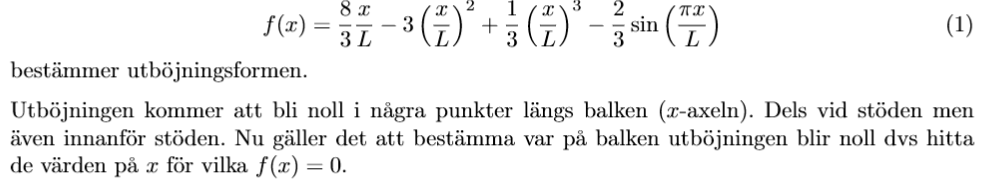


x_0* = 0.0
x_1* = 0.298729872987
x_2* = 0.842384238424
x_3* = 1.0


Text(0.5, 1.0, '$f(x)$')

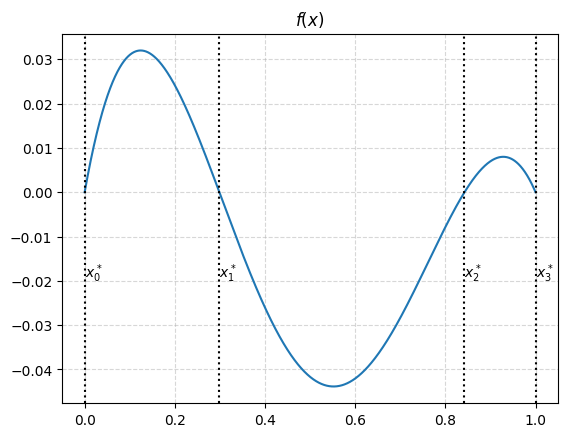

In [313]:
import numpy as np
from matplotlib import pyplot as plt

def bend_func(x: np.ndarray, L: float = 1) -> np.ndarray:
    return (8/3) * (x/L) - 3*(x/L)**2 + (1/3)*(x/L)**3 - (2/3)*np.sin(np.pi * x / L)

def dx_bend_func(x: np.ndarray, L: float = 1) -> np.ndarray:
    return (8/3)/L - 6*x/L**2 + x**2/L**3 - (2*np.pi/(3*L))*np.cos(np.pi * x / L)

def fixed_point_func(x: float, L: float = 1) -> np.ndarray:    
    return (3 * L / 8)*( 3* (x/L) - 3 * (x / L)**2 + (1 / 3) * (x / L)**3 - (2 / 3) * np.sin(np.pi * x / L))

x: np.ndarray = np.linspace(0, 1, 10000)
y: np.ndarray = bend_func(x, L=1)

zeroes: np.ndarray = x[np.abs(y) < 1e-5].round(12)

plt.plot(x, y)
i: int = 0
for val in zeroes:
    plt.axvline(zeroes[i], color='black', linestyle='dotted')
    plt.annotate(
        fr"$x_{{{i}}}^*$",
        xy=(val, 0),
        xytext=(0, -50),
        textcoords="offset points",
        ha="left",
        va="top"
    )
    print(f'x_{i}* = {val}')
    i += 1

plt.grid(linestyle='--', alpha=0.5)
plt.title(r"$f(x)$")



###  **Svar 1.A:** *Förutom vid stöden finns 2 nollpunkter.*

## 1.b) 
Vilket eller vilka av nollställen kan bestämmas med fixpunktsiterationsmetoden? Motivera ditt svar teoretiskt.

 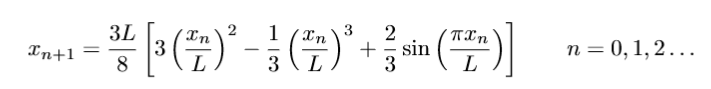



Använd **konvergensanalys**:
För *fixpunktsiteration* gäller att den konvergerar lokalt omm:

$c < 1$, där $c = |g'(x^*)|$

låt $x_{n+1} = g(x)$ $\implies$ 
$ \left| g'(x) \right|
  = \Biggl| \frac{3L}{8}\left[ 6\frac{x}{L}
    - \left(\frac{x}{L}\right)^{2}
    + \frac{2 \pi}{3 L}\cos\!\left(\frac{\pi x}{L}\right)
    \right] \Biggr|
$

Convergence analysis:
x_0* = 0.0                  converges.                |g´(x_0*)| = 0.785398163397 < 1
x_1* = 0.298729872987       does not converge.        |g´(x_1*)| = 1.102854552316 > 1
x_2* = 0.842384238424       converges.                |g´(x_2*)| = 0.938195915424 < 1
x_3* = 1.0                  does not converge.        |g´(x_3*)| = 1.089601836603 > 1


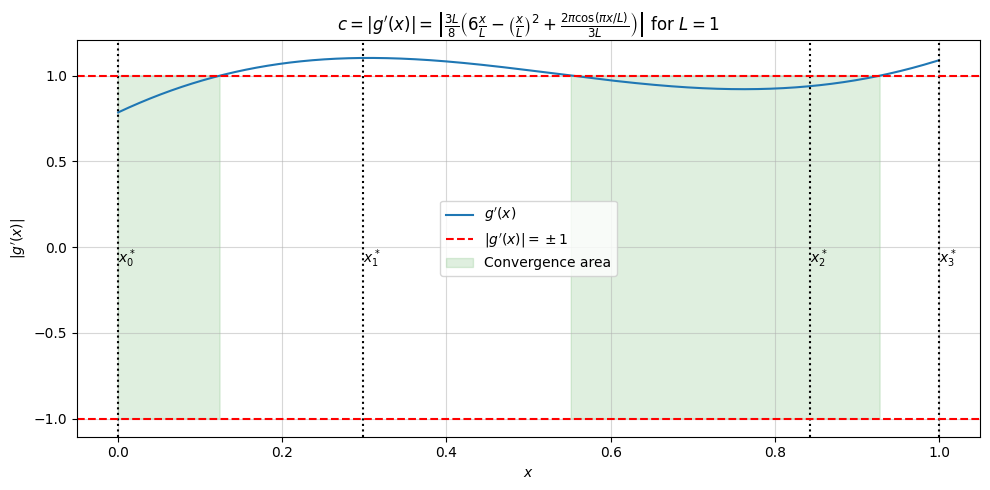

In [314]:
import numpy as np
import matplotlib.pyplot as plt


def g_prim(x: np.ndarray, L: float = 1) -> np.ndarray:
    from numpy import pi
    return (3 * L / 8) * (
        6 * x / L
        - (x / L) ** 2
        + (2 * pi * np.cos(pi * x / L)) / (3 * L)
    )


L: int = 1
x: np.ndarray = np.linspace(0, 1, 100000)
y: np.ndarray = abs(g_prim(x, L))

plt.figure(figsize=(10, 5))
plt.plot(x, y, label=r"$g'(x)$")

i:int = 0
print('Convergence analysis:')
for val in zeroes:
    c: np.ndarray = abs(g_prim(val, L)).round(12)
    plt.axvline(zeroes[i], color='black', linestyle='dotted')
    plt.annotate(
        fr"$x_{{{i}}}^*$",
        xy=(val, 0),
        xytext=(0, 0),
        textcoords="offset points",
        ha="left",
        va="top"
    )
    if c < 1:
        print(f'x_{i}* = {val:<20} converges. {'':<15}|g´(x_{i}*)| = {c} < 1')
    else:
        print(f'x_{i}* = {val:<20} does not converge. {'':<6} |g´(x_{i}*)| = {c} > 1')

    i += 1

plt.axhline(1, color="r", linestyle="dashed", label=r"$|g'(x)| = \pm 1$")
plt.axhline(-1, color="r", linestyle="dashed")
plt.fill_between(x, -1, 1, where=(y<1) , color='g', alpha=0.125, label = "Convergence area") #type: ignore

plt.xlabel(r"$x$")
plt.ylabel(r"$|g'(x)|$")
plt.title(r"$c = |g'(x)| = \left| \frac{3L}{8} \left( 6\frac{x}{L} - \left(\frac{x}{L}\right)^2 + \frac{2\pi \cos(\pi x / L)}{3L} \right) \right|$ for $L=1$")

plt.grid(True, alpha = 0.5)
plt.tight_layout()
plt.legend()
plt.show()


## 1.c)
Skriv ett Python-program som beräknar ett av de nollställen på intervallet 0 < x < L
för vilka fixpunktsmetoden konvergerar.
Programmet ska ha en utskrift som visar hur metoden konvergerar till nollstället samt
returnera ett svar med ett fel som är mindre än en given tolerans τ = 10e−10. Använd
lämpligt avbrottsvillkor för att säkerställa detta.


In [315]:
from tabulate import tabulate
from dataclasses import dataclass
from typing import Callable


@dataclass
class FixedPointResult:
    xs: list[float]
    ns: list[int]
    deltaX: list[float]


def fixed_point_iteration(
    g: Callable[[float], float],
    x0: float,
    tolerance: float,
    max_iterations: int,
) -> FixedPointResult:
    xs: list[float] = []
    ns: list[int] = []
    deltaX: list[float] = []

    """
    Fixed point iteration to find a fixed point of g starting from x0.
    Args:
        g: function for fixed point iteration
        x0: initial guess
        tolerance: convergence tolerance
        max_iterations: maximum number of iterations
    Returns:
        FixedPointResult containing the list of approximations and iteration counts
    Raises:
        RuntimeError: if the method does not converge within max_iterations

    """


    x = x0
    DeltaX = tolerance + 1.0
    n = 0

    while DeltaX > tolerance and n < max_iterations:
        xs.append(x)
        ns.append(n)
        deltaX.append(DeltaX)

        xold = x
        x = g(xold)
        DeltaX = float(np.abs(x - xold))
        n += 1

    if n >= max_iterations and DeltaX > tolerance:
        raise RuntimeError("Fixed point iteration did not converge within max_iterations.")

    return FixedPointResult(xs=xs, ns=ns, deltaX=deltaX)


TOLERANCE = 10e-10
MAX_ITER = 1000
x_2 = zeroes[2]

fixed_point_results = fixed_point_iteration(fixed_point_func, x_2, TOLERANCE, MAX_ITER) # type: ignore
table_data = [
    [n, x, dx] for n, x, dx in zip(fixed_point_results.ns, fixed_point_results.xs, fixed_point_results.deltaX)
]

print(tabulate(
    table_data,
    headers=["n", "x_n", "Δx_n"],
    floatfmt=".12f",
    tablefmt="fancy_outline"
))




╒═════╤════════════════╤════════════════╕
│   n │            x_n │           Δx_n │
╞═════╪════════════════╪════════════════╡
│   0 │ 0.842384238424 │ 1.000000001000 │
│   1 │ 0.105296220239 │ 0.737088018185 │
│   2 │ 0.024931546293 │ 0.080364673946 │
│   3 │ 0.007789471156 │ 0.017142075137 │
│   4 │ 0.002577728036 │ 0.005211743120 │
│   5 │ 0.000867950178 │ 0.001709777858 │
│   6 │ 0.000293910896 │ 0.000574039281 │
│   7 │ 0.000099715535 │ 0.000194195362 │
│   8 │ 0.000033852394 │ 0.000065863141 │
│   9 │ 0.000011495046 │ 0.000022357348 │
│  10 │ 0.000003903590 │ 0.000007591456 │
│  11 │ 0.000001325649 │ 0.000002577941 │
│  12 │ 0.000000450191 │ 0.000000875458 │
│  13 │ 0.000000152885 │ 0.000000297305 │
│  14 │ 0.000000051920 │ 0.000000100965 │
│  15 │ 0.000000017632 │ 0.000000034288 │
│  16 │ 0.000000005988 │ 0.000000011644 │
│  17 │ 0.000000002034 │ 0.000000003954 │
│  18 │ 0.000000000691 │ 0.000000001343 │
╘═════╧════════════════╧════════════════╛


## 1.d) 
Utöka Python-programmet ovan så att det beräknar ett av nollställena på intervallet
0 < x < L till (1) med hjälp av Newtons metod. Välj ett nollställe som inte går att
bestämma med fixpunktsmetoden.

In [316]:

@dataclass
class NewtonRaphsonResult:
    xs: list[float]
    ns: list[int]
    deltas: list[float]

def NewtonRaphson(f_of_x: Callable, dx_f_of_x: Callable, x0: float, tolerance: float, max_iterations: int) ->     NewtonRaphsonResult:
    ns: list[int] = []
    xs: list[float] = []
    deltas: list[float] = []
    
    """
    Newton-Raphson method to find a root of f starting from x0.
    Args:
        f_of_x: One variabe function that returns a callable f(x)
        dx_f_of_x: One variable function that is equal to the derivative of f_of_x and returns a callable dxf(x).
        x0: initial guess
        tolerance: convergence tolerance
        max_iterations: maximum number of iterations
    Returns:
        Dataclass containing the list of approximations, deltas, and iteration counts

    """


    x = x0
    DeltaX = tolerance + 1.0
    n = 0

    xs.append(x)
    deltas.append(DeltaX)
    ns.append(n)


    while DeltaX > tolerance and n < max_iterations:
        n += 1
        f = f_of_x(x)
        df = dx_f_of_x (x)
        x_new = x - (f / df)
        DeltaX = np.abs(x_new - x)
        x = x_new

        ns.append(n)
        xs.append(x)
        deltas.append(DeltaX)

    return NewtonRaphsonResult(xs=xs, deltas=deltas, ns=ns)


x_1 = zeroes[1]

newton_results = NewtonRaphson(bend_func, dx_bend_func, x_1, TOLERANCE, MAX_ITER)
table_data = [
    [n, x, dx] for n, x, dx in zip(newton_results.ns, newton_results.xs, newton_results.deltas)
]

print(tabulate(
    table_data,
    headers=["n", "x_n", "Δx_n"],
    floatfmt=".12f",
    tablefmt="fancy_outline"
))


╒═════╤════════════════╤════════════════╕
│   n │            x_n │           Δx_n │
╞═════╪════════════════╪════════════════╡
│   0 │ 0.298729872987 │ 1.000000001000 │
│   1 │ 0.298743646196 │ 0.000013773209 │
│   2 │ 0.298743646163 │ 0.000000000033 │
╘═════╧════════════════╧════════════════╛


## 1.e)
Nu ska konvergenshastigheten för de två metoderna jämföras. Välj ett nollställe där
bägge metoderna konvergerar. Använd samma startgissning för båda fallen. Beräkna
nollstället och plotta $|x_{n+1} −x_n|$ som funktion av n för bägge metoderna i samma figur.
Du kan använda en matplotlib.pyplot.semilogy-plot för att få logskala på y-axeln.


Vad kan man utläsa av figuren?

Ser figuren ut som du förväntar dig?

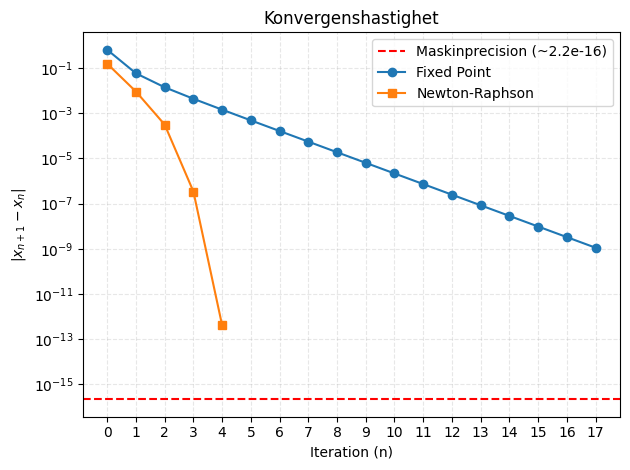

In [ ]:

machine_epsilon:float  = float(np.finfo(float).eps)
x0: float = 0.7
TOLERANCE = 1e-9
MAX_ITER = 10000

fixed_point_results: FixedPointResult = fixed_point_iteration(fixed_point_func, x0, TOLERANCE, MAX_ITER) # type: ignore
newton_results: NewtonRaphsonResult = NewtonRaphson(bend_func, dx_bend_func, x0, TOLERANCE, MAX_ITER)

fpr_delta: np.ndarray = np.abs(np.diff(fixed_point_results.xs))
nr_delta: np.ndarray = np.abs(np.diff(newton_results.xs))

n_fpr_delta: np.ndarray = np.arange(len(fpr_delta))
n_nr_delta: np.ndarray = np.arange(len(nr_delta))
max_n: int = max(len(n_nr_delta), len(n_fpr_delta))

plt.axhline(y=machine_epsilon, color='r', linestyle='--', 
            label=f'Maskinprecision (~{machine_epsilon:.1e})', linewidth=1.5)
plt.semilogy(n_fpr_delta, fpr_delta, 'o-', label='Fixed Point')
plt.semilogy(n_nr_delta, nr_delta, 's-', label='Newton-Raphson')
plt.xlabel('Iteration (n)')
plt.ylabel(r'$|x_{n+1} - x_n|$')
plt.xticks(range(0, max_n, 1))
plt.title('Konvergenshastighet')
plt.legend()
plt.grid(True, alpha=0.3, linestyle='dashed')
plt.tight_layout()
plt.show()






## Svar 1.e) 

Figuren ser ut som väntat då vi förväntar oss att Newton-Raphson metoden konvergerar snabbare.

Vi kan se att Newton-Raphsonmetoden har $\sim$ kvadratisk konvergens och når maskinprecision på 4 iterationer.

Fixpunksiterationsmetoden visar linjär konvergenshastighet och når toleransnivån efter 17 iterationer.

_____
